Running this file will make a csv file called pca_transformed_data.csv which will contain the new features to use for K means clustering (which explain 95% of the variance)

In [1]:

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler



In [ ]:

df = pd.read_csv('data/knnData/BA_US_knn_text.csv')

In [3]:

df.head(3)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,user_id,appearance,aroma,palate,taste,overall,rating,text,avg,user_state,beer_state
0,Kupfer Kolsch,289320.0,Copper State Brewing Company,49595.0,Kölsch,4.4,n2185.211743,2.50,4.00,4.00,3.75,3.75,3.76,NaN,3.76,North Carolina,Wisconsin
1,Northwestern Alt,289321.0,Copper State Brewing Company,49595.0,Altbier,4.6,n2185.211743,3.00,3.75,4.00,3.50,3.50,3.58,NaN,3.58,North Carolina,Wisconsin
2,One Cent Wheat,289319.0,Copper State Brewing Company,49595.0,Witbier,5.4,n2185.211743,3.75,3.25,3.75,3.50,3.50,3.48,NaN,3.48,North Carolina,Wisconsin


In [4]:
columns_to_drop = ['beer_name', 'beer_id','brewery_name','avg','user_state', 'beer_state', 'text']

# Drop the specified columns as well as dropping ratings with no text reviews
X_drop_na = df.dropna()
X_drop = X_drop_na.drop(columns=columns_to_drop)
y = df['user_state']

print(X_drop.shape)
X_drop.head(3)

(1829363, 10)


,brewery_id,style,abv,user_id,appearance,aroma,palate,taste,overall,rating
50,939.0,Munich Helles Lager,5.2,scaliasux.16164,4.00,4.00,3.5,3.50,4.00,3.75
53,939.0,Munich Helles Lager,5.2,jwc215.53566,3.25,3.25,3.5,3.25,3.25,3.28
62,939.0,Munich Helles Lager,5.2,cagocubs.283312,2.50,3.00,3.5,3.50,3.50,3.32


In [5]:
X = X_drop
#one hot encode beer style
#frequency encode brewery_id and user_id

X = pd.get_dummies(X, columns=['style'], prefix=['style'])
user_frequency = X['user_id'].value_counts() / len(X)  # Frequency of each user_id

#Map each user_id to its frequency
X['user_id_encoded'] = X['user_id'].map(user_frequency)
brewery_frequency = X['brewery_id'].value_counts() / len(X)  # Frequency of each brewery_id

#Map each brewery_id to its frequency
X['brewery_id_encoded'] = X['brewery_id'].map(brewery_frequency)
X = X.drop(columns=['user_id', 'brewery_id'])

#label encoding target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X.head(3)


,abv,appearance,aroma,palate,taste,overall,rating,style_Altbier,style_American Adjunct Lager,style_American Amber / Red Ale,...,style_Scottish Gruit / Ancient Herbed Ale,style_Smoked Beer,style_Tripel,style_Vienna Lager,style_Weizenbock,style_Wheatwine,style_Winter Warmer,style_Witbier,user_id_encoded,brewery_id_encoded
50,5.2,4.00,4.00,3.5,3.50,4.00,3.75,False,False,False,...,False,False,False,False,False,False,False,False,0.000170,0.000015
53,5.2,3.25,3.25,3.5,3.25,3.25,3.28,False,False,False,...,False,False,False,False,False,False,False,False,0.001498,0.000015
62,5.2,2.50,3.00,3.5,3.50,3.50,3.32,False,False,False,...,False,False,False,False,False,False,False,False,0.000114,0.000015


In [6]:
#covariance matrix to remove highly correlated variables first
corr_matrix = X.corr()  # Compute correlation matrix for your features\n",

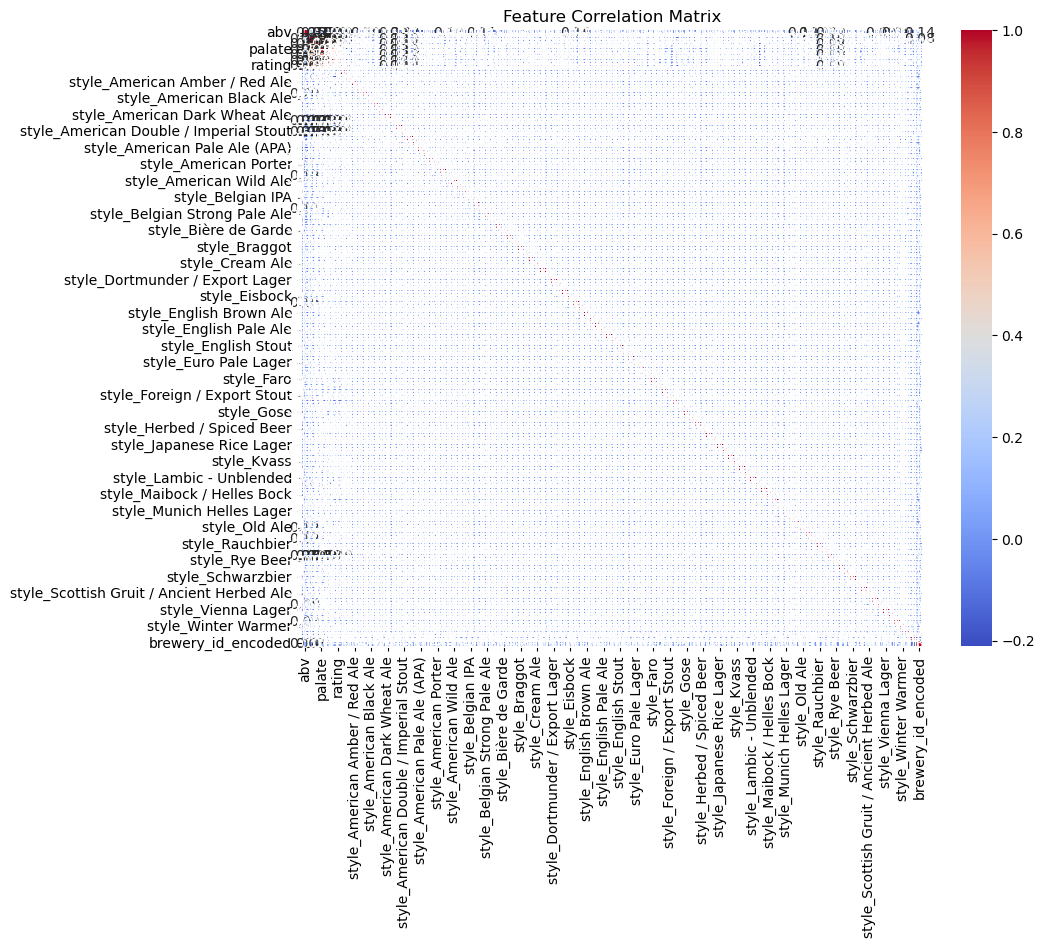

Highly correlated features with correlation > 0.8:
    Feature_1 Feature_2  Correlation
230     aroma    rating     0.857140
342    palate    rating     0.823379
453     taste   overall     0.841406
454     taste    rating     0.957886
564   overall     taste     0.841406
566   overall    rating     0.906449
674    rating     aroma     0.857140
675    rating    palate     0.823379
676    rating     taste     0.957886
677    rating   overall     0.906449


In [7]:

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.show()

threshold = 0.8
high_corr_pairs = corr_matrix.abs().unstack().reset_index()
high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']

# Filter for correlations above threshold and remove self-correlations
high_corr_pairs = high_corr_pairs[
    (high_corr_pairs['Correlation'] > threshold) & 
    (high_corr_pairs['Feature_1'] != high_corr_pairs['Feature_2'])
]

# Display features
print("Highly correlated features with correlation > 0.8:")
print(high_corr_pairs)

Manually removing features based on the correlation coefficient threshold of 0.8: Remove aroma (since rating is central and likely more informative).
Remove palate (same reasoning).
Remove overall (keep taste or vice versa)

In [8]:
features_to_remove = ['aroma', 'palate', 'overall']
X = X.drop(columns=features_to_remove)

In [9]:
scaler = RobustScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X_scaled = X_scaled.dropna()
print(X_scaled.head())


   abv  appearance  taste    rating  style_Altbier  \
0 -0.5         0.0  -0.50 -0.313433            0.0   
1 -0.5        -1.0  -0.75 -1.014925            0.0   
2 -0.5        -2.0  -0.50 -0.955224            0.0   
3 -0.5         0.0   0.00  0.134328            0.0   
4 -0.5         0.0   0.50  0.731343            0.0   

   style_American Adjunct Lager  style_American Amber / Red Ale  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   style_American Amber / Red Lager  style_American Barleywine  \
0                               0.0                        0.0   
1                               0.0                        0.0   
2                               0.0                        0.0   
3       

In [19]:
# Initialize PCA - Set the number of components you want
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)
X_pca_df = pd.DataFrame(X_pca)


# Create a DataFrame of the PCA components
# Each column represents a principal component and each row corresponds to the feature contribution to that component
components_df = pd.DataFrame(pca.components_, columns=X_scaled.columns)

# Display the contributions of features to each principal component
print(components_df)

         abv  appearance     taste    rating  style_Altbier  \
0   0.238847    0.464923  0.484243  0.649604      -0.001223   
1   0.037763    0.109478  0.124665  0.170600       0.000184   
2   0.194402   -0.046844 -0.084214 -0.108617      -0.002249   
3   0.924373   -0.075715 -0.134315 -0.161338      -0.002425   
4  -0.041769    0.865501 -0.389930 -0.308844       0.000466   
5   0.098396   -0.030920 -0.015701 -0.003369      -0.004367   
6  -0.038349   -0.015802 -0.024132  0.004360      -0.002629   
7  -0.061286   -0.012034 -0.031216  0.017663      -0.002664   
8   0.091718   -0.003682 -0.009843  0.003481      -0.004894   
9   0.022861   -0.007080 -0.006876 -0.000759      -0.004179   
10  0.010942    0.001827  0.032240 -0.021787      -0.001906   
11 -0.078344   -0.004392  0.021292 -0.015057       0.004110   
12 -0.019998   -0.022563 -0.014700  0.012912      -0.007011   
13  0.000131   -0.025491 -0.140375  0.100859      -0.007669   
14  0.011453   -0.036035 -0.288101  0.252244      -0.00

In [21]:
X_pca_df

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.403559,-0.423929,-0.928445,-0.332123,0.331993,-0.140588,-0.047128,-0.016731,-0.070423,-0.044114,...,-0.022585,-0.004032,0.004938,0.001855,0.024860,0.020456,0.005616,-0.009943,-0.019304,-0.008218
1,-1.935785,1.493646,-0.259902,-0.179736,-0.209203,-0.094416,-0.008755,-0.001414,-0.068713,-0.030748,...,-0.012127,-0.004456,-0.000711,0.001323,0.017636,0.013694,0.003237,-0.006557,-0.011955,-0.005809
2,-1.729522,-0.844689,-0.787277,-0.074176,-1.201227,-0.076966,-0.019152,-0.004332,-0.065209,-0.029637,...,-0.003189,-0.006623,-0.002276,0.001040,0.014830,0.007952,0.003647,-0.008031,-0.007477,0.001340
3,-0.139464,0.908600,-0.731709,-0.509938,0.004315,-0.145033,-0.046500,-0.020116,-0.074877,-0.045680,...,-0.022141,-0.003392,0.004453,0.003003,0.024846,0.018809,0.006160,-0.008714,-0.018987,-0.009549
4,0.821753,-0.397967,-1.192828,-0.626088,-0.381903,-0.160948,-0.069196,-0.030493,-0.076376,-0.052296,...,-0.022645,-0.003886,0.006133,0.003730,0.026927,0.018424,0.007755,-0.010378,-0.020193,-0.008027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1829358,-1.360917,-0.872239,-0.731921,0.311644,0.196728,-0.166466,-0.126723,0.416442,0.823866,0.108940,...,0.012137,-0.002314,0.001554,-0.002939,-0.016321,-0.003852,-0.001112,0.004724,0.007418,0.005212
1829359,-0.421502,-0.501082,-0.978902,-0.415414,-0.461513,-0.137763,-0.048096,-0.020260,-0.083391,-0.047895,...,-0.019874,-0.004366,0.000905,0.002691,0.035939,0.024428,0.010777,-0.011739,-0.024801,-0.006748
1829360,-2.455030,-0.892905,-0.629669,0.073388,0.007916,-0.088066,-0.006766,0.008668,-0.071480,-0.031501,...,-0.018062,-0.007462,-0.001558,0.000448,0.030224,0.023920,0.005160,-0.014696,-0.023481,-0.006730
1829361,-4.140729,-1.428024,-0.362773,0.513999,0.978238,-0.066399,0.008360,0.006342,-0.068102,-0.023364,...,-0.003592,-0.001814,-0.007213,-0.004246,0.026810,0.024605,0.008970,-0.002274,-0.010903,0.003356


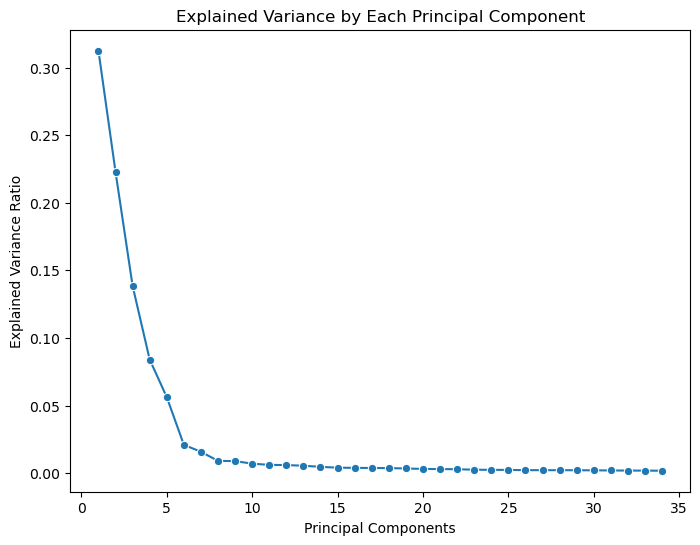

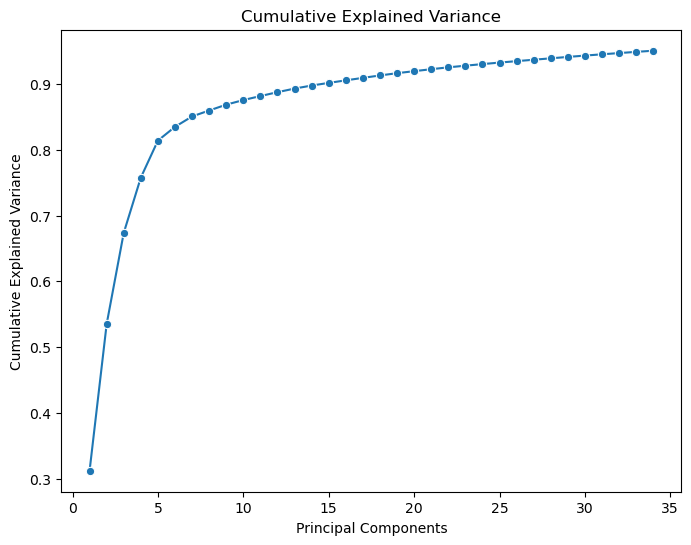

In [16]:
plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_) + 1),
             y=pca.explained_variance_ratio_, marker='o')
plt.title('Explained Variance by Each Principal Component')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.show()

plt.figure(figsize=(8, 6))
sns.lineplot(x=range(1, len(pca.explained_variance_ratio_) + 1),
             y=np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title('Cumulative Explained Variance')
plt.xlabel('Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

In [ ]:

components_df = pd.DataFrame(pca.components_, columns=X_scaled.columns)
# For each principal component, get the top 5 features based on absolute contribution
top_features = {}
for i in range(components_df.shape[0]):
    # Sort the components by absolute value, and get the top x feature names
    top_features[i] = components_df.iloc[i].abs().sort_values(ascending=False).head(3).index.tolist()


for i, features in top_features.items():
    print(f"Principal Component {i+1}: {features}")

Principal Component 1: ['rating', 'taste', 'appearance']
Principal Component 2: ['user_id_encoded', 'brewery_id_encoded', 'rating']
Principal Component 3: ['brewery_id_encoded', 'user_id_encoded', 'abv']
Principal Component 4: ['abv', 'brewery_id_encoded', 'rating']
Principal Component 5: ['appearance', 'taste', 'rating']
Principal Component 6: ['style_American IPA', 'style_American Double / Imperial IPA', 'style_American Pale Ale (APA)']
Principal Component 7: ['style_American Double / Imperial IPA', 'style_American Double / Imperial Stout', 'style_American IPA']
Principal Component 8: ['style_American Double / Imperial Stout', 'style_American Pale Ale (APA)', 'style_Russian Imperial Stout']
Principal Component 9: ['style_American Pale Ale (APA)', 'style_American Double / Imperial Stout', 'style_Russian Imperial Stout']
Principal Component 10: ['style_American Porter', 'style_American Amber / Red Ale', 'style_Saison / Farmhouse Ale']
Principal Component 11: ['style_American Amber / Re